Prashant P. Singh - 8448315

In [1]:
# Lets mount the Google Drive and acccess the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
import pickle
path = '/content/drive/MyDrive/IMDB/'  # path to the folder in google drive where data is saved
with open(path + "train.pkl", 'rb') as a, open(path + "test.pkl", 'rb') as b:
    d_train = pickle.load(a)   # loading training data
    d_test = pickle.load(b)   # loading test data 

#### Download the glove.6B vector file, it's glove word vector representation created from co-occurence of words from the corpus of Wikipedia and [Gigaword5](https://catalog.ldc.upenn.edu/LDC2011T07). We will also use the glove.twitter.27B as this might be better suited for our sentiment (likes,dislikes,hate etc)

[Glove](https://nlp.stanford.edu/projects/glove/)

"The training objective of GloVe is to learn word vectors such that their dot product equals the logarithm of the words' probability of co-occurrence.". Why this makes sense? In taking the ratio of probabilities we are able to amplify the diffferentiating effect between two words given the context.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-12-01 12:05:38--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-12-01 12:05:39--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-12-01 12:05:39--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
# saving the files to Google drive
!unzip "/content/glove.6B.zip" -d "/content/drive/MyDrive/IMDB/"

Archive:  /content/glove.6B.zip
  inflating: /content/drive/MyDrive/IMDB/glove.6B.50d.txt  
  inflating: /content/drive/MyDrive/IMDB/glove.6B.100d.txt  
  inflating: /content/drive/MyDrive/IMDB/glove.6B.200d.txt  
  inflating: /content/drive/MyDrive/IMDB/glove.6B.300d.txt  


In [ ]:
# downlaoding and extracting the glove.twitter to IMDB folder in Google Drive
! wget https://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip "/content/glove.twitter.27B.zip" -d "/content/drive/MyDrive/IMDB/"

--2021-12-01 13:24:47--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2021-12-01 13:24:47--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip’

glove.twitter.27B.z 100%[===================>]   1.42G  4.04MB/s    in 10m 50s 

2021-12-01 13:35:39 (2.23 MB/s) - ‘glove.twitter.27B.zip’ saved [1520408563/1520408563]

Archive:  /content/glove.twitter.27B.zip
  inflating: /content/d

In [29]:
# lets build custom tokenizer adapted for this corpus
# https://www.tensorflow.org/addons/tutorials/networks_seq2seq_nmt
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

import tensorflow as tf
def tokenize(lang, num_words = None):
        # lang = list of sentences in a language

        # lets select the default config and basic Tokenizer from keras
        
        lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<OOV>', num_words= num_words)

        # this step is necessary to allow tokenzier build its words id for the corpus 
        # from the lang = list of sentences
        lang_tokenizer.fit_on_texts(lang)

        ## tf.keras.preprocessing.text.Tokenizer.texts_to_sequences converts string (w1, w2, w3, ......, wn) 
        ## to a list of correspoding integer ids of words (id_w1, id_w2, id_w3, ...., id_wn)
        tensor = lang_tokenizer.texts_to_sequences(lang) 

        ## tf.keras.preprocessing.sequence.pad_sequences takes argument a list of integer id sequences 
        ## and pads the sequences to match the longest sequences in the given input
        # this will make all sentences of same length
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

        return tensor, lang_tokenizer

In [30]:
# this will return the lang_tokenizer and trianing data set adapted to maxlen and max_features(number of words to consider in vocab)
# why not test? we will be using the lang_tokenizer on test to transform.

def create_data(max_features = 20000, maxlen = 200):
  from tensorflow import keras
  # max_features = 20000     # Only considering the top 20k words, which can be tuned
  # maxlen = 200          # Only considering the first 200 words of each movie review which can be tuned

  train_text, lang_tokenizer = tokenize(d_train.text, num_words= max_features)
  print("Words corpus is ", len(lang_tokenizer.word_index))

  X_train = lang_tokenizer.texts_to_sequences(d_train.text) 
 
  # reduce all sentences to size of 200, if sentence is less than this size will add padding of zero
  X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen, padding='post')

  return lang_tokenizer, X_train

In [31]:
max_features = 40000  # from previous run, without embedding we saw that 40k is good value for max_features
maxlen = 200    
lang_tokenizer, X_train = create_data(max_features,maxlen)

# building the token: index mapping from lang_tokenizer object (for vocab restrcited to max_features)
word_index  = {k: lang_tokenizer.word_index[k] for k in list(lang_tokenizer.word_index)[:max_features]}

Words corpus is  96044


In [32]:
# Embedding_matrix creation

def create_emb_matrix(embedding_, embedding_dim):
  import numpy as np

  #path to embedding file
  path_to_file = '/content/drive/MyDrive/IMDB/' + embedding_   

  embeddings_index = {}
  with open(path_to_file) as f:
      for line in f:
          word, coefs = line.split(maxsplit=1)
          coefs = np.fromstring(coefs, "f", sep=" ")
          embeddings_index[word] = coefs
  f.close()
  print("Found %s word vectors." % len(embeddings_index))

  num_tokens = max_features

  # book keeping to check how many words out of 40k we get in glove embedding.
  hits = 0
  misses = 0

  # Prepare embedding matrix
  embedding_matrix = np.zeros((num_tokens, embedding_dim))
  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # Words not found in embedding index will be all-zeros.
          # This includes the representation for "padding" and "OOV"
          embedding_matrix[i] = embedding_vector
          hits += 1
      else:
          misses += 1
  print("Converted %d words (%d misses)" % (hits, misses))

  return embedding_matrix


In [7]:
# for using the RADAM
! pip install tensorflow_addons


     |▎                               | 10 kB 24.2 MB/s eta 0:00:01
     |▋                               | 20 kB 31.0 MB/s eta 0:00:01
     |▉                               | 30 kB 32.7 MB/s eta 0:00:01
     |█▏                              | 40 kB 23.7 MB/s eta 0:00:01
     |█▌                              | 51 kB 19.8 MB/s eta 0:00:01
     |█▊                              | 61 kB 13.5 MB/s eta 0:00:01
     |██                              | 71 kB 12.8 MB/s eta 0:00:01
     |██▍                             | 81 kB 14.2 MB/s eta 0:00:01
     |██▋                             | 92 kB 14.2 MB/s eta 0:00:01
     |███                             | 102 kB 15.4 MB/s eta 0:00:01
     |███▎                            | 112 kB 15.4 MB/s eta 0:00:01
     |███▌                            | 122 kB 15.4 MB/s eta 0:00:01
     |███▉                            | 133 kB 15.4 MB/s eta 0:00:01
     |████▏                           | 143 kB 15.4 MB/s eta 0:00:01
     |████▍                           | 15

In [40]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras import initializers
import pandas as pd

def create_model(embedding_matrix, optimizer = 'adam', init = 'glorot_uniform', lstm_cell_size = 64,
                dropout_rate_dense = 0.1, embedding_size = 100, max_features = 40000, r_dropout = 0.2, skip = False):
  
  # Input for variable-length sequences of integers
  inputs = keras.Input(shape=(None,))

  # Embed each integer in a 128-dimensional vector
  x = layers.Embedding(input_dim= len(word_index), trainable = True, mask_zero= True,
                       embeddings_initializer= initializers.Constant(embedding_matrix),
                       output_dim = embedding_size)(inputs)

  #  2 bidirectional LSTMs
  lstm1 = layers.Bidirectional(layers.LSTM(lstm_cell_size, return_sequences=True, dropout = 0.1,
                                       kernel_initializer = init, recurrent_dropout = r_dropout,
                                       recurrent_initializer = init))(x)
  if skip == False:
      x = layers.Bidirectional(layers.LSTM(lstm_cell_size, dropout = 0.1,
                                        kernel_initializer = init,recurrent_dropout = r_dropout,
                                       recurrent_initializer = init))(lstm1)
  else:
      x = layers.Concatenate()([lstm1,x])
      x = layers.Bidirectional(layers.LSTM(lstm_cell_size, dropout = 0.1,
                                        kernel_initializer = init,recurrent_dropout = r_dropout,
                                       recurrent_initializer = init))(x)
  x = layers.Dropout(0.1)(x)

  # Dense layer 
  x = layers.Dense(50, activation="relu")(x)

  # prediction layer
  outputs = layers.Dense(1, activation="sigmoid")(x)

  model = keras.Model(inputs = inputs, outputs = outputs)

  model.summary()
  return model

In [43]:
def display_history(history,name ="None"):

    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np                                        
#   #   """Summarize history for accuracy and loss.

    sns.set_palette("pastel")
    sns.set(style="darkgrid")
    path = '/content/drive/MyDrive/IMDB/'

    # loss plot for valid and train
    fig, ax = plt.subplots(figsize=(10,6),sharey='row')
    title = "Loss_for_{}".format(name)
    sns.lineplot(data=history.history['loss'], ax = ax)
    sns.lineplot(data=history.history['val_loss'], ax = ax)
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.title(title)
    fig.savefig( path + title + '.png')

    # accuracy plot for valid and train
    
    fig, ax = plt.subplots(figsize=(10,6),sharey='row')
    title = "Accuracy_for_{}".format(name)
    sns.lineplot(data=history.history['accuracy'], ax = ax)
    sns.lineplot(data=history.history['val_accuracy'], ax = ax)
    ax.set_xlabel('epoch')
    ax.set_ylabel('accuracy')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.title(title)
    fig.savefig( path + title + '.png')


In [35]:
# As stated earlier we will be using the validation set created from train to fine tune the model paramters. 
# Further being s satndard dataset the accuracy levels are reported on test batch of 25k, therefore for ebtter comaprison we are not going to
# use test set for validation.

X_train, X_val, y_train, y_val = train_test_split(X_train, d_train.label, train_size=0.8, random_state= 7)

# saving the history object for plot and further analysis
historys = []

# book keeping
report = pd.DataFrame(columns = ['model','Val_loss','Valid_accuracy', 'Test_Val','Test_accuracy']) 


In [36]:
# applying tokenizer on test data set
X_test = lang_tokenizer.texts_to_sequences(d_test.text)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen, padding='post')
y_test = d_test.label

Found 400000 word vectors.
Converted 36969 words (3031 misses)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         4000000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        84480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                

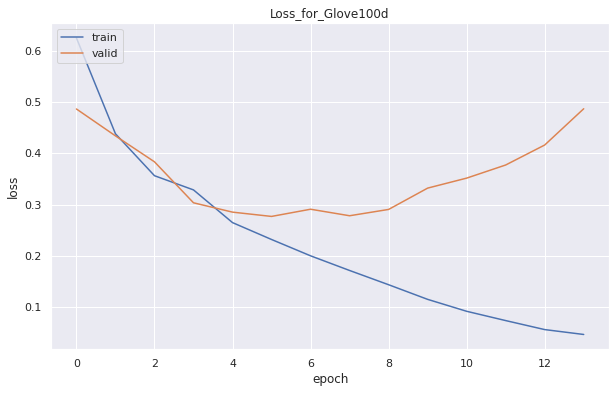

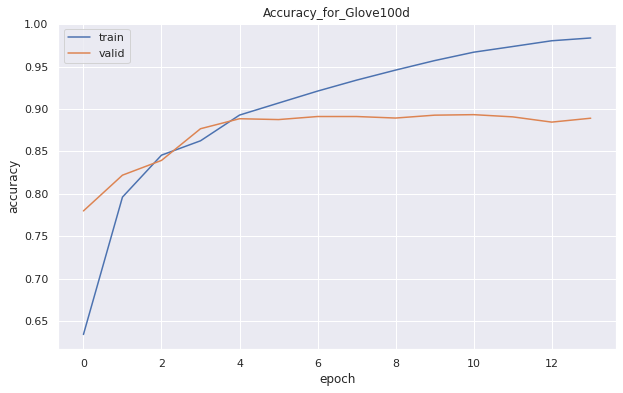

In [42]:
from numpy.random import seed
import tensorflow as tf
from tensorflow.keras import backend as be
from sklearn.metrics import accuracy_score
import pandas as pd 
from sklearn.model_selection import train_test_split

be.clear_session()
tf.compat.v1.reset_default_graph()

from numpy.random import seed
seed(7)

tf.random.set_seed(7)
batchsize = 32
epoch = 20

# using glove100d, 100 represenst the embedding layer dimension
name = 'Glove100d'
embedding_size = 100
embedding_matrix = create_emb_matrix('glove.6B.100d.txt',embedding_size)


# param for early stopping, number of epoch to wait before terminating the process, if no improvmenet seen for the monitored quantity
patience = 3


# will be used in callback to stop the training process if no improvment seen. We can keep the monitored quantity as val_loss, however here we
# are using val_accuracy as that is the metric on which we are benchmarking the models
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=patience,
                                                  mode='max', restore_best_weights = False)

model = create_model(embedding_matrix= embedding_matrix, embedding_size= embedding_size)

# here we aheva incorporated the decay also in learning rate. the Learning rate will first go from zero to lr value in warm-up phase
# and then drop from that value to min_lr over the remaining steps.
model.compile(optimizer=RectifiedAdam(learning_rate = 0.001, warmup_proportion = 0.1, beta_1 = 0.9, total_steps= 10000, min_lr= 0.0005),
            loss='binary_crossentropy',
            metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=batchsize, epochs= epoch, validation_data=(X_val, y_val),callbacks=[early_stopping])
display_history(history,name)
historys.append(history)

print("Evaluating on valid set...{}".format(name))
(val_loss, val_accuracy) = model.evaluate(X_val, y_val)
print("loss={:.4f}, accuracy: {:.4f}%".format(val_loss,val_accuracy * 100))
print("Evaluating on test set...{}".format(name))
(test_loss, test_accuracy) = model.evaluate(X_test, y_test)
print("loss={:.4f}, accuracy: {:.4f}%".format(test_loss,test_accuracy * 100))
report.loc[len(report)] = [name,val_loss, val_accuracy, test_loss, test_accuracy]
print(report)

Found 400000 word vectors.
Converted 36969 words (3031 misses)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 200)         8000000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        135680    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                

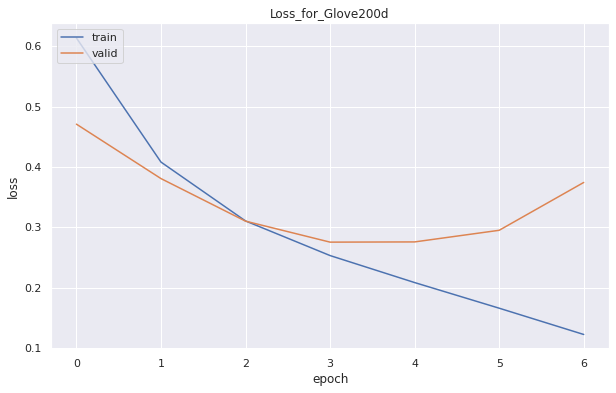

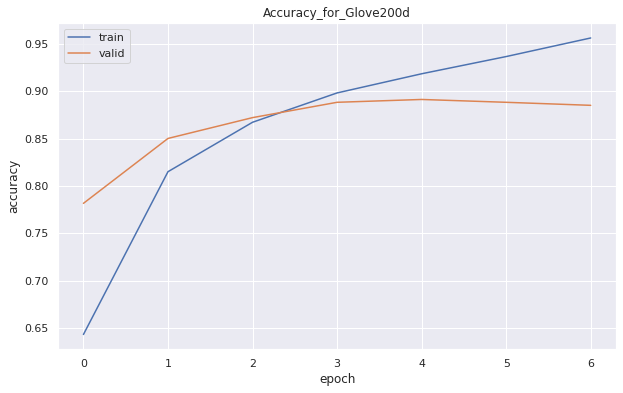

In [45]:
from numpy.random import seed
import tensorflow as tf
from tensorflow.keras import backend as be
from sklearn.metrics import accuracy_score
import pandas as pd 
from sklearn.model_selection import train_test_split

be.clear_session()
tf.compat.v1.reset_default_graph()

from numpy.random import seed
seed(7)

tf.random.set_seed(7)
batchsize = 32
epoch = 20

# using glove200d, 200 represenst the embedding layer dimension
name = 'Glove200d'
embedding_size = 200
embedding_matrix = create_emb_matrix('glove.6B.200d.txt',embedding_size)

patience = 2
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=patience,
                                                  mode='max', restore_best_weights = False)

model = create_model(embedding_matrix= embedding_matrix, embedding_size= embedding_size)
model.compile(optimizer=RectifiedAdam(learning_rate = 0.001, warmup_proportion = 0.1, beta_1 = 0.9, total_steps= 10000, min_lr= 0.0005),
            loss='binary_crossentropy',
            metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=batchsize, epochs= epoch, validation_data=(X_val, y_val),callbacks=[early_stopping])
display_history(history,name)
historys.append(history)

print("Evaluating on valid set...{}".format(name))
(val_loss, val_accuracy) = model.evaluate(X_val, y_val)
print("loss={:.4f}, accuracy: {:.4f}%".format(val_loss,val_accuracy * 100))
print("Evaluating on test set...{}".format(name))
(test_loss, test_accuracy) = model.evaluate(X_test, y_test)
print("loss={:.4f}, accuracy: {:.4f}%".format(test_loss,test_accuracy * 100))
report.loc[len(report)] = [name,val_loss, val_accuracy, test_loss, test_accuracy]
print(report)

In [46]:
report
# increasing the dimension size improves the test accuracy

,model,Val_loss,Valid_accuracy,Test_Val,Test_accuracy
0,Glove100d,0.486813,0.8892,0.526118,0.88024
1,Glove200d,0.374457,0.8852,0.379650,0.88160


Found 1193514 word vectors.
Converted 34638 words (5362 misses)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 200)         8000000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        336896    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                               

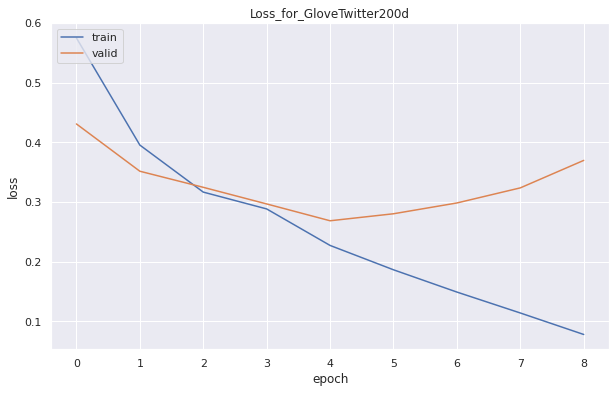

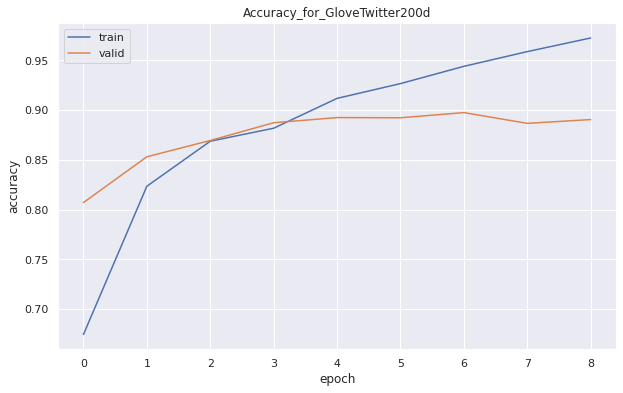

In [47]:
from numpy.random import seed
import tensorflow as tf
from tensorflow.keras import backend as be
from sklearn.metrics import accuracy_score
import pandas as pd 
from sklearn.model_selection import train_test_split

be.clear_session()
tf.compat.v1.reset_default_graph()

from numpy.random import seed
seed(7)

tf.random.set_seed(7)
batchsize = 32
epoch = 20

# trying the glove embedding with twitter data
name = 'GloveTwitter200d'
embedding_size = 200
embedding_matrix = create_emb_matrix('glove.twitter.27B.200d.txt',embedding_size)
patience = 2
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=patience,
                                                  mode='max', restore_best_weights = False)

model = create_model(embedding_matrix= embedding_matrix, embedding_size= embedding_size, lstm_cell_size= 128)
model.compile(optimizer=RectifiedAdam(learning_rate = 0.001, warmup_proportion = 0.1, beta_1 = 0.9, total_steps= 10000, min_lr= 0.0005),
            loss='binary_crossentropy',
            metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=batchsize, epochs= epoch, validation_data=(X_val, y_val),callbacks=[early_stopping])
display_history(history,name)
historys.append(history)

print("Evaluating on valid set...{}".format(name))
(val_loss, val_accuracy) = model.evaluate(X_val, y_val)
print("loss={:.4f}, accuracy: {:.4f}%".format(val_loss,val_accuracy * 100))
print("Evaluating on test set...{}".format(name))
(test_loss, test_accuracy) = model.evaluate(X_test, y_test)
print("loss={:.4f}, accuracy: {:.4f}%".format(test_loss,test_accuracy * 100))
report.loc[len(report)] = [name,val_loss, val_accuracy, test_loss, test_accuracy]
print(report)

In [48]:
report

,model,Val_loss,Valid_accuracy,Test_Val,Test_accuracy
0,Glove100d,0.486813,0.8892,0.526118,0.88024
1,Glove200d,0.374457,0.8852,0.379650,0.88160
2,GloveTwitter200d,0.369977,0.8906,0.379811,0.88600


In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = float(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = float(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

def model_plot(df):
  # Reshaping dataframe in  way to make it compatible to pass it to seaborn
  
#   df = pd.melt(report, id_vars=["model","TFIDF"], var_name="Type", value_name="Accuracy Score")
  # df = pd.melt(report, id_vars="model", var_name="Type", value_name="Accuracy Score")
   
  # some fancy thing to make plots nice, you can different palette types and style
  # https://seaborn.pydata.org/tutorial/color_palettes.html
  
  sns.set_palette("pastel")
  sns.set(style="darkgrid")
  fig, ax = plt.subplots( figsize=(20,6))
  a = sns.barplot(data=df, x="model", y= 'Accuracy Score', hue="Type", ax = ax)
  a.set_title('Accuracy Score for Models')
  show_values_on_bars(a, "v", 0.5)
  plt.legend(loc='lower right')
  fig.savefig(path + "Finalplot_PretrainedEmbedding"+ '.png')

In [52]:
report.to_csv(path + 'PretrainedEmbedding.csv')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


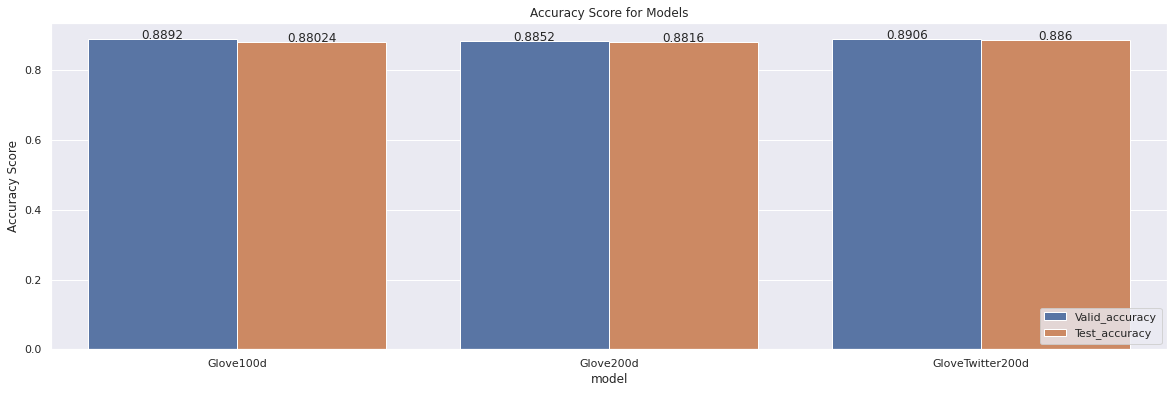

In [53]:
df = report[['model','Valid_accuracy','Test_accuracy']]
df[['Valid_accuracy','Test_accuracy']]  = df[['Valid_accuracy','Test_accuracy']].round(decimals = 5)
df = pd.melt(df, id_vars=["model"], var_name="Type", value_name="Accuracy Score")
model_plot(df)

Takeways: Increasing the dimension surely helps but it comes with computation cost. the more btter thing is to do look for pre-trained embedding with the corpus which reflects the semantics of your corpus. Example: Imagine using the pretrained embedding of scientific corpus of lets say physics articles. If you use the same, then words like 'iron fist', 'solid benchmark' etc will get wrong semantic representation as this embedding is not suited for the context. Therefore a caution should be employed using the pre-trained embedding. While the model had shown the improvement over the LSTM simple model, but this can be improved further by increasing the sentence length, n-grams, max_features and changing the architecture too by incorporating Convolutional layer and fine tuning the learning rate. One such change will be next step in terms of incorporating n-grams using FASTtext.

References:

https://github.com/JoshWuuu/Machine-Learning-based-classification-for-Sentimental-analysis-of-IMDb-reviews/tree/master/Sequence_model